In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import lagrange
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
np.random.seed(42)

#### The dataset has been uploaded here https://drive.google.com/drive/folders/1A7nruNtceXMPl6LfNk693xkmbf5Fjl2Z?usp=sharing:

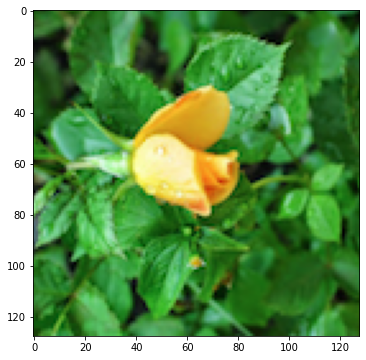

In [ ]:
image = cv2.imread("0210.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(image)

In [ ]:
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

In [ ]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

## Separation Index

In [ ]:
def separation_index_2(X,labels,centroids,M=3):
    wss = np.zeros(M)
    for m in range(M):
        cluster_indices = np.where(labels == m)[0]
        if len(cluster_indices) == 0:
            wss[m] = 0
        else:
            cluster_points = X[cluster_indices, :]
            centroid = centroids[m, :]
            wss[m] = np.sum(np.linalg.norm(cluster_points - centroid, axis=1)**2)
    n = X.shape[0]
    si_num = 0
    for m in range(M):
        for j in range(n):
            if labels[j] == m:
                mu_jm = 1
            else:
                mu_jm = 0
            x_j = X[j, :]
            c_m = centroids[m, :]
            si_num += mu_jm**2 * np.linalg.norm(x_j - c_m)**2

    min_dist = np.inf
    for k in range(M):
        for m in range(k+1, M):
            dist = np.linalg.norm(centroids[k, :] - centroids[m, :])**2
            if dist < min_dist:
                min_dist = dist

    si_den = n * min_dist

    si = si_num / si_den
    return si


#Partition Index


In [ ]:
def partition_index_2(X, labels,centers):
    """
    Compute the Partition Index (PI) given a set of data points, centers,
    and their corresponding labels.

    Parameters
    ----------
    X : numpy array, shape (n_samples, n_features)
        The input data points.

    centers : numpy array, shape (n_centers, n_features)
        The centers of the clusters.

    labels : numpy array, shape (n_samples,)
        The cluster assignments for each data point.

    Returns
    -------
    float
        The Partition Index.

    """
    n_samples = X.shape[0]
    n_centers = centers.shape[0]

    # Compute the within-cluster sum of squares for each cluster
    within_cluster_sums = np.zeros(n_centers)
    for i in range(n_samples):
        m = labels[i]
        diff = X[i] - centers[m]
        within_cluster_sums[m] += np.dot(diff, diff)

    # Compute the numerator of the PI equation for each center
    numerators = np.zeros(n_centers)
    for m in range(n_centers):
        Nm = np.sum(labels == m)
        for j in range(n_samples):
            mu_jm = 1.0 if labels[j] == m else 0.0
            diff = X[j] - centers[m]
            numerators[m] += mu_jm**2 * np.dot(diff, diff)

    # Compute the denominator of the PI equation for each center
    denominators = np.zeros(n_centers)
    for m in range(n_centers):
        for k in range(n_centers):
            diff = centers[k] - centers[m]
            denominators[m] += np.dot(diff, diff)

    # Compute the PI for the clustering
    PI = 0.0
    for m in range(n_centers):
        PI += numerators[m] / (within_cluster_sums[m] * denominators[m])

    PI *= 1.0 / n_centers

    return PI

## Dunn Index

In [ ]:
def dunn_index_2(X, labels):
    """
    Compute Dunn's index for a clustering solution.
    X: array-like, shape=(n_samples, n_features)
        Data matrix.
    labels: array-like, shape=(n_samples,)
        Cluster labels for each sample.
    """
    n_clusters = len(set(labels))
    cluster_diameters = np.zeros(n_clusters)
    for i in range(n_clusters):
        # Compute intra-cluster diameter
        cluster_points = X[labels == i]
        if len(cluster_points) > 1:
            cluster_distances = np.linalg.norm(cluster_points[:, np.newaxis, :] - cluster_points[np.newaxis, :, :], axis=-1)
            cluster_diameters[i] = np.max(cluster_distances)
    
    intercluster_distances = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            # Compute inter-cluster distance
            points_i = X[labels == i]
            points_j = X[labels == j]
            centroid_i = np.mean(points_i, axis=0)
            centroid_j = np.mean(points_j, axis=0)
            intercluster_distances[i, j] = np.linalg.norm(centroid_i - centroid_j)
            intercluster_distances[j, i] = intercluster_distances[i, j]
    
    max_intradist = np.max(cluster_diameters)
    min_interdist = np.min(intercluster_distances[intercluster_distances > 0])
    return min_interdist/max_intradist

## K-Means

In [ ]:
class KMeans():
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []
    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        
        # initialize 
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]
        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)
            if self.plot_steps:
                self.plot()
            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            
            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break
            if self.plot_steps:
                self.plot()
        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)
    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels
    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index
    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids
    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0
    def cent(self):
        return self.centroids

In [ ]:
k = KMeans(K=3, max_iters=100)  
y_pred = k.predict(pixel_values) 
y_pred = y_pred.astype(int)
centers_k = np.uint8(k.cent())

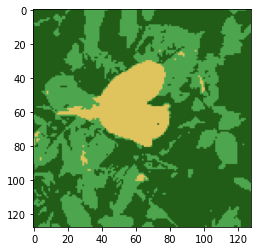

In [ ]:
labels_k = y_pred.flatten()
segmented_image = centers_k[labels_k.flatten()]
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)
plt.show()

In [ ]:
#GSI
silhouette_score(pixel_values, labels_k) 

0.51359606

In [ ]:
print("Separation Index",separation_index_2(pixel_values,labels_k,centers_k))
print("Dunn Index",dunn_index_2(pixel_values, labels_k))
print("Partition Index",partition_index_2(pixel_values,labels_k,centers_k))

Separation Index 0.19101412285139066
Dunn Index 0.32708304512868397
Partition Index 0.006041936277247289


#Fuzzy-C Means

In [ ]:
def fuzzy_c_means(pixel_values,k,m=2,max_iter=300):
    # Initialize the cluster centers randomly
    n_samples, n_features = pixel_values.shape
    cluster_centers = np.random.rand(k, n_features)

    # Initialize the membership matrix randomly
    membership_matrix = np.random.rand(n_samples, k)

    # Normalize the membership matrix
    for i in range(n_samples):
        membership_matrix[i, :] = membership_matrix[i, :] / np.sum(membership_matrix[i, :])

    # Iterate until convergence
    for iteration in range(max_iter):
        # print(iteration)
        # Update the cluster centers
        for j in range(k):
            numerator = 0
            denominator = 0
            for i in range(n_samples):
                numerator += np.power(membership_matrix[i, j], m) * pixel_values[i, :]
                denominator += np.power(membership_matrix[i, j], m)
            cluster_centers[j, :] = numerator / denominator
            
        # Update the membership matrix
        for i in range(n_samples):
            for j in range(k):
                numerator = np.linalg.norm(pixel_values[i, :] - cluster_centers[j, :])
                denominator = 0
                for l in range(k):
                    denominator += np.power(numerator / np.linalg.norm(pixel_values[i, :] - cluster_centers[l, :]), 2 / (m - 1))
                membership_matrix[i, j] = 1 / denominator

    # Assign the samples to the closest cluster center
    labels = np.argmax(membership_matrix, axis=1)
    cluster_centers = np.uint8(cluster_centers)
    
    return cluster_centers, labels

In [ ]:
center_f, label_f =  fuzzy_c_means(pixel_values,3)

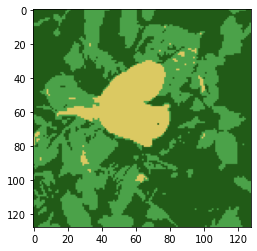

In [ ]:
segmented_image = center_f[label_f.flatten()]
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)
plt.show()

In [ ]:
#GSI
silhouette_score(pixel_values, label_f)

0.5088006

In [ ]:
print("Separation Index",separation_index_2(pixel_values,label_f,center_f))
print("Dunn Index",dunn_index_2(pixel_values, label_f))
print("Partition Index",partition_index_2(pixel_values,label_f,center_f))

Separation Index 0.2087592370380608
Dunn Index 0.321285880294442
Partition Index 0.005284047599038111


##IMC-1

In [ ]:
def imc1(pixel_values,max_iter=3):
    pixel_values_real = pixel_values
    clusters = [-1] * len(pixel_values)
    cluster_id = 0
    cluster_center = []
    cluster_center_normalised = []
    indexes = [i for i in range(len(pixel_values))]
    pixel_values = (pixel_values -np.min(pixel_values,axis=0))/(np.max(pixel_values,axis=0) - np.min(pixel_values,axis=0)) #normalised
    pixel_values_copy = pixel_values

    for i in range(max_iter):
        noise = []
        noise_real=[]
        indexes2 =[]
  
        d1 = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) #bandwidth
        D = squareform(pdist(pixel_values, lambda x, y: np.exp(-np.sum((x - y) ** 2) / (d1 ** 2))))  #Potential value
 
        maxima = np.argmax(np.sum(D,axis=1))  #max of the potential value for the center
# Assign points to clusters or noise
        for idx,j in enumerate(indexes):
            if clusters[j] == -1:
                distance = np.sum((pixel_values[idx] - pixel_values[maxima]) ** 2)
                if distance <= d1:
                    clusters[j] = cluster_id
                else:
                    noise_real.append(pixel_values_real[idx])
                    noise.append(pixel_values[idx])
                    indexes2.append(j)

        cluster_center.append(pixel_values_real[maxima])
        cluster_center_normalised.append(pixel_values[maxima])

        pixel_values = np.asarray(noise) #left out points assigned for next iteration
        pixel_values_real = np.asarray(noise_real)
        indexes = indexes2
        cluster_id+=1

    for idx,sample in enumerate(pixel_values_copy):
        if clusters[idx] == -1: #assigning the left out points to clusters
            distances = [euclidean_distance(sample, point) for point in cluster_center_normalised]
            clusters[idx] = np.argmin(distances)
    
    clusters = np.asarray(clusters)
    clusters = clusters.astype(int)

    cluster_center = np.uint8(cluster_center)
    
    return cluster_center, cluster_center_normalised, clusters

In [ ]:
cluster_center, cluster_center_normalised, clusters = imc1(pixel_values)

(16384, 3)


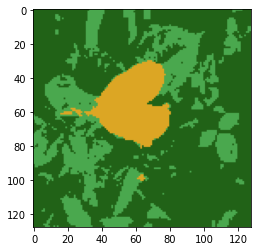

In [ ]:
segmented_image = cluster_center[clusters.flatten()]
print(segmented_image.shape)
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)
plt.show()

In [ ]:
#GSI
silhouette_score(pixel_values, clusters)

0.5123625

In [ ]:
separation_index_2(pixel_values,clusters,cluster_center)

0.18340623014409144

In [ ]:
dunn_index_2(pixel_values, clusters)

0.3444944733539187

In [ ]:
partition_index_2(pixel_values,clusters,cluster_center)

0.006061371698075817

##IMC-2

In [ ]:
def imc2(pixel_values,max_iter=3, M=3):
    pixel_values_real = pixel_values
    clusters = [-1] * len(pixel_values)
    cluster_id = 0
    cluster_center = []
    cluster_center_normalised = []
    indexes = [i for i in range(len(pixel_values))]
    pixel_values = (pixel_values -np.min(pixel_values,axis=0))/(np.max(pixel_values,axis=0) - np.min(pixel_values,axis=0)) #normalised
    pixel_values_copy = pixel_values

    for i in range(max_iter):
        noise = []
        noise_real=[]
        indexes2 =[]
  
        d1 = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * (M/(M+1)) #bandwidth
        D = squareform(pdist(pixel_values, lambda x, y: np.exp(-np.sum((x - y) ** 2) / (d1 ** 2))))  #Potential value
 
        maxima = np.argmax(np.sum(D,axis=1))  #max of the potential value for the center
# Assign points to clusters or noise
        for idx,j in enumerate(indexes):
            if clusters[j] == -1:
                distance = np.sum((pixel_values[idx] - pixel_values[maxima]) ** 2)
                if distance <= d1:
                    clusters[j] = cluster_id
                else:
                    noise_real.append(pixel_values_real[idx])
                    noise.append(pixel_values[idx])
                    indexes2.append(j)

        cluster_center.append(pixel_values_real[maxima])
        cluster_center_normalised.append(pixel_values[maxima])

        pixel_values = np.asarray(noise)  #left out points assigned for next iteration
        pixel_values_real = np.asarray(noise_real)
        indexes = indexes2
        cluster_id+=1
    
    for idx,sample in enumerate(pixel_values_copy):
        if clusters[idx] == -1: #assigning the left out points to clusters
            distances = [euclidean_distance(sample, point) for point in cluster_center_normalised]
            clusters[idx] = np.argmin(distances)
    
    clusters = np.asarray(clusters)
    clusters = clusters.astype(int)

    cluster_center = np.uint8(cluster_center)
    
    return cluster_center, cluster_center_normalised, clusters

In [ ]:
cluster_center, cluster_center_normalised, clusters = imc2(pixel_values)

(16384, 3)


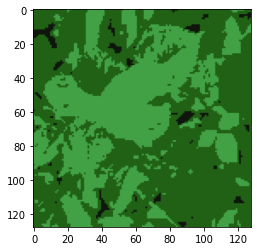

In [ ]:
segmented_image = cluster_center[clusters.flatten()]
print(segmented_image.shape)
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)
plt.show()

In [ ]:
#GSI
silhouette_score(pixel_values, clusters)

0.35922188

In [ ]:
separation_index_2(pixel_values,clusters,cluster_center)

0.7760834704363514

In [ ]:
dunn_index_2(pixel_values, clusters)

0.2748311447556545

In [ ]:
partition_index_2(pixel_values,clusters,cluster_center)

0.0048495477291513305

##Self-Optimal Clustering

In [ ]:
def soc(pixel_values,iters=10, M=3):
    pixel_values_real = np.copy(pixel_values)
    pixel_values_real_copy= np.copy(pixel_values)
    clusters_m = np.full(len(pixel_values),-1)
    cluster_id = 0
    cluster_center_m = []
    cluster_center_normalised_m = []
    indexes = [i for i in range(len(pixel_values))]
    pixel_values = (pixel_values -np.min(pixel_values,axis=0))/(np.max(pixel_values,axis=0) - np.min(pixel_values,axis=0)) #normalised
    pixel_values_copy = np.copy(pixel_values)

    cluster_center = []
    cluster_center_normalised = []
    clusters = []
    bandwidth = []
    beta = []
    S = []
    GSI = []
    eta = []
    S_m = np.zeros(M)
    beta_m = np.ones(M)
    d_m = np.zeros(M)

    for k in range(iters):

        for i in range(M):
            noise = []
            noise_real=[]
            indexes2 =[]

            d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth
            D = squareform(pdist(pixel_values, lambda x, y: np.exp(-np.sum((x - y) ** 2) / (d_m[i] ** 2))))  #Potential value
    
            maxima = np.argmax(np.sum(D,axis=1))  #max of the potential value for the center
    # Assign points to clusters or noise
            for idx,j in enumerate(indexes):
                if clusters_m[j] == -1:
                    distance = np.sum((pixel_values[idx] - pixel_values[maxima]) ** 2)
                    if distance <= d_m[i]:
                        clusters_m[j] = cluster_id
                    else:
                        noise_real.append(pixel_values_real[idx])
                        noise.append(pixel_values[idx])
                        indexes2.append(j)

            cluster_center_m.append(pixel_values_real[maxima])
            cluster_center_normalised_m.append(pixel_values[maxima])

            pixel_values = np.asarray(noise) #left out points assigned for next iteration
            pixel_values_real = np.asarray(noise_real)
            indexes = indexes2
            cluster_id+=1
        
        for idx,sample in enumerate(pixel_values_copy):
            if clusters_m[idx] == -1: #assigning the left out points to clusters
                distances = [euclidean_distance(sample, point) for point in cluster_center_normalised_m]
                clusters_m[idx] = np.argmin(distances)
        
        clusters_m = clusters_m.astype(int)

        cluster_center_m = np.uint8(cluster_center_m)
        print("pixel_Values_real_copy",pixel_values_real_copy)
        print("pixel_values_copy",pixel_values_copy)
        sil = silhouette_samples(pixel_values_copy,clusters_m)

        for x in range(M): #calculating S_m for each cluster
            S1=[]
            for j in range(len(pixel_values_copy)):
                if(clusters_m[j]==x):
                    S1.append(sil[j])
            S1 = np.asarray(S1)   
            S_m[x] = np.mean(S1)

        print("d_m",d_m)
        print("S_m",S_m)
        poly = lagrange(d_m, S_m)  #making the lagrange polynomial with d_m and S_m
        poly = poly - 1
        print("poly",poly)
        roots = np.roots(poly.coef) #finding the roots d_t
        poly = poly + 1
        poly_eval = np.polyval(poly.coef,roots)
        
        eta_m = roots[np.argmax(poly_eval)] #eta is the value of the root at which value of S_t is highest
        print("eta_m",eta_m)
        beta_m = eta_m/d_m  #beta_m to be used for next iteration
        print("beta_m",beta_m)

        cluster_center.append(cluster_center_m)
        print("Cluster_Center", cluster_center)
        cluster_center_normalised.append(cluster_center_normalised_m)
        print("Cluster_Center_normalised", cluster_center_normalised)
        clusters.append(np.copy(clusters_m))
        print("Clusters", clusters)
        bandwidth.append(np.copy(d_m))
        print("bandwidth", bandwidth)
        beta.append(np.copy(beta_m))
        print("beta", beta_m)
        S.append(np.copy(S_m))
        print("S", S)
        eta.append(eta_m) 
        print("eta", eta)       
        GSI.append(silhouette_score(pixel_values_copy, clusters_m))
        print("GSI", GSI)

        clusters_m = np.full(len(pixel_values_copy),-1)
        cluster_id = 0
        cluster_center_m = []
        cluster_center_normalised_m = []
        indexes = [i for i in range(len(pixel_values_copy))]
        pixel_values = pixel_values_copy
        pixel_values_real = pixel_values_real_copy
        
        
    return cluster_center,cluster_center_normalised,clusters,bandwidth,beta,S,eta,GSI

In [ ]:
cluster_center,cluster_center_normalised,clusters,bandwidth,beta,S,eta,GSI = soc(pixel_values)

pixel_Values_real_copy [[ 23.  69.  13.]
 [ 26.  72.  15.]
 [ 33.  72.  22.]
 ...
 [ 48. 116.  35.]
 [ 49. 112.  31.]
 [ 45. 101.  19.]]
pixel_values_copy [[0.09055118 0.27058825 0.05439331]
 [0.10236221 0.28235295 0.06276151]
 [0.12992126 0.28235295 0.09205021]
 ...
 [0.18897638 0.45490196 0.14644352]
 [0.19291338 0.4392157  0.12970711]
 [0.17716536 0.39607844 0.07949791]]
d_m [0.0902056  0.10402621 0.09167073]
S_m [0.53572023 0.49637383 0.40944865]
poly       2
6745 x - 1313 x + 63.09
eta_m 0.10826068871865115
beta_m [1.20015482 1.04070593 1.18097331]
Cluster_Center [array([[ 33,  98,  23],
       [ 74, 168,  78],
       [220, 166,  36]], dtype=uint8)]
Cluster_Center_normalised [[array([0.12992126, 0.38431373, 0.09623431], dtype=float32), array([0.2913386 , 0.65882355, 0.32635984], dtype=float32), array([0.86614174, 0.6509804 , 0.15062761], dtype=float32)]]
Clusters [array([0, 0, 0, ..., 0, 0, 0])]
bandwidth [array([0.0902056 , 0.10402621, 0.09167073])]
beta [1.20015482 1.04070593 1.

<ipython-input-5-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 23.  69.  13.]
 [ 26.  72.  15.]
 [ 33.  72.  22.]
 ...
 [ 48. 116.  35.]
 [ 49. 112.  31.]
 [ 45. 101.  19.]]
pixel_values_copy [[0.09055118 0.27058825 0.05439331]
 [0.10236221 0.28235295 0.06276151]
 [0.12992126 0.28235295 0.09205021]
 ...
 [0.18897638 0.45490196 0.14644352]
 [0.19291338 0.4392157  0.12970711]
 [0.17716536 0.39607844 0.07949791]]
d_m [0.08923963 0.10256124 0.09446319]
S_m [0.536331   0.49516472 0.40920305]
poly       2
2624 x - 506.3 x + 23.83
eta_m 0.11163126585744994
beta_m [1.25091589 1.08843521 1.18174357]
Cluster_Center [array([[ 33,  98,  23],
       [ 74, 168,  78],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,  98,  23],
       [ 74, 166,  77],
       [220, 166,  36]], dtype=uint8)]
Cluster_Center_normalised [[array([0.12992126, 0.38431373, 0.09623431], dtype=float32), array([0.2913386 , 0.65882355, 0.32635984], dtype=float32), array([0.86614

<ipython-input-5-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 23.  69.  13.]
 [ 26.  72.  15.]
 [ 33.  72.  22.]
 ...
 [ 48. 116.  35.]
 [ 49. 112.  31.]
 [ 45. 101.  19.]]
pixel_values_copy [[0.09055118 0.27058825 0.05439331]
 [0.10236221 0.28235295 0.06276151]
 [0.12992126 0.28235295 0.09205021]
 ...
 [0.18897638 0.45490196 0.14644352]
 [0.19291338 0.4392157  0.12970711]
 [0.17716536 0.39607844 0.07949791]]
d_m [0.08831127 0.10117576 0.09834581]
S_m [0.53727299 0.49431628 0.40926391]
poly       2
3328 x - 633.9 x + 29.57
eta_m 0.10892461763193835
beta_m [1.23341691 1.07658807 1.10756744]
Cluster_Center [array([[ 33,  98,  23],
       [ 74, 168,  78],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,  98,  23],
       [ 74, 166,  77],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,  98,  23],
       [ 74, 166,  77],
       [220, 166,  36]], dt

<ipython-input-5-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 23.  69.  13.]
 [ 26.  72.  15.]
 [ 33.  72.  22.]
 ...
 [ 48. 116.  35.]
 [ 49. 112.  31.]
 [ 45. 101.  19.]]
pixel_values_copy [[0.09055118 0.27058825 0.05439331]
 [0.10236221 0.28235295 0.06276151]
 [0.12992126 0.28235295 0.09205021]
 ...
 [0.18897638 0.45490196 0.14644352]
 [0.19291338 0.4392157  0.12970711]
 [0.17716536 0.39607844 0.07949791]]
d_m [0.08690021 0.09919115 0.10188505]
S_m [0.53863579 0.49221301 0.40995625]
poly        2
-1786 x + 328.5 x - 15.52
eta_m (0.09198806888924008-0.015247621197054327j)
beta_m [1.05854833-0.17546128j 0.92738184-0.15371958j 0.90286126-0.14965513j]
Cluster_Center [array([[ 33,  98,  23],
       [ 74, 168,  78],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,  98,  23],
       [ 74, 166,  77],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33, 

<ipython-input-5-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 23.  69.  13.]
 [ 26.  72.  15.]
 [ 33.  72.  22.]
 ...
 [ 48. 116.  35.]
 [ 49. 112.  31.]
 [ 45. 101.  19.]]
pixel_values_copy [[0.09055118 0.27058825 0.05439331]
 [0.10236221 0.28235295 0.06276151]
 [0.12992126 0.28235295 0.09205021]
 ...
 [0.18897638 0.45490196 0.14644352]
 [0.19291338 0.4392157  0.12970711]
 [0.17716536 0.39607844 0.07949791]]
d_m [0.09548699 0.09661805 0.0823034 ]
S_m [0.52926952 0.50060934 0.41348898]
poly        2
-2384 x + 432.6 x - 20.04
eta_m (0.09073734977557334-0.013225834101087469j)
beta_m [0.95025878-0.13850928j 0.93913455-0.13688782j 1.10247393-0.16069609j]
Cluster_Center [array([[ 33,  98,  23],
       [ 74, 168,  78],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,  98,  23],
       [ 74, 166,  77],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33, 

<ipython-input-5-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 23.  69.  13.]
 [ 26.  72.  15.]
 [ 33.  72.  22.]
 ...
 [ 48. 116.  35.]
 [ 49. 112.  31.]
 [ 45. 101.  19.]]
pixel_values_copy [[0.09055118 0.27058825 0.05439331]
 [0.10236221 0.28235295 0.06276151]
 [0.12992126 0.28235295 0.09205021]
 ...
 [0.18897638 0.45490196 0.14644352]
 [0.19291338 0.4392157  0.12970711]
 [0.17716536 0.39607844 0.07949791]]
d_m [0.08571867 0.09759175 0.10230504]
S_m [0.54001558 0.49066931 0.41060624]
poly         2
-773.6 x + 137.6 x - 6.575
eta_m (0.08896883489410436-0.02416753250079107j)
beta_m [1.03791671-0.28194014j 0.91164295-0.24763908j 0.86964277-0.23623014j]
Cluster_Center [array([[ 33,  98,  23],
       [ 74, 168,  78],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,  98,  23],
       [ 74, 166,  77],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,

<ipython-input-5-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 23.  69.  13.]
 [ 26.  72.  15.]
 [ 33.  72.  22.]
 ...
 [ 48. 116.  35.]
 [ 49. 112.  31.]
 [ 45. 101.  19.]]
pixel_values_copy [[0.09055118 0.27058825 0.05439331]
 [0.10236221 0.28235295 0.06276151]
 [0.12992126 0.28235295 0.09205021]
 ...
 [0.18897638 0.45490196 0.14644352]
 [0.19291338 0.4392157  0.12970711]
 [0.17716536 0.39607844 0.07949791]]
d_m [0.0936259  0.09487702 0.08044065]
S_m [0.52681631 0.50873232 0.40284342]
poly        2
-1653 x + 297.1 x - 13.8
eta_m (0.0898781063003671+0.016501242185180516j)
beta_m [0.95997053+0.17624655j 0.94731168+0.17392244j 1.11732193+0.2051356j ]
Cluster_Center [array([[ 33,  98,  23],
       [ 74, 168,  78],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,  98,  23],
       [ 74, 166,  77],
       [220, 166,  36]], dtype=uint8), array([[ 35, 100,  24],
       [ 81, 172,  88],
       [220, 166,  36]], dtype=uint8), array([[ 33,  9

In [ ]:
SOC_cluster_centers = cluster_center[np.argmax(GSI)]
SOC_labels = clusters[np.argmax(GSI)]

(16384, 3)


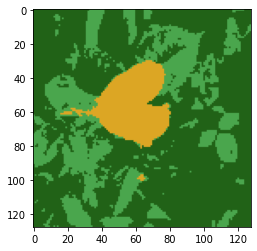

In [ ]:
segmented_image = SOC_cluster_centers[SOC_labels.flatten()]
print(segmented_image.shape)
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)
plt.show()

In [ ]:
#GSI
np.max(GSI)

0.51432467

In [ ]:
partition_index_2(pixel_values,SOC_labels,SOC_cluster_centers)

2.2462588538198448e-05

In [ ]:
separation_index_2(pixel_values,SOC_labels,SOC_cluster_centers)

0.25089992601382033

In [ ]:
dunn_index_2(pixel_values, SOC_labels)

0.3245515580442525

###Image 2

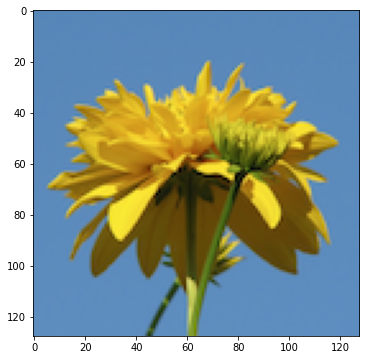

In [ ]:
image_2 = cv2.imread("0014.png")
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(image_2)

In [ ]:
pixel_values_2 = image_2.reshape((-1, 3))
pixel_values_2 = np.float32(pixel_values_2)

##To know the optimal number of clusters k which maximizes the GSI

In [ ]:
clus = [2,3,4,5,6,7]
gsi_s = []
for i in clus:
    k = KMeans(K=i, max_iters=100)  
    y_pred = k.predict(pixel_values_2) 
    y_pred = y_pred.astype(int)
    centers = np.uint8(k.cent())
    labels = y_pred.flatten()
    gsi_s.append(silhouette_score(pixel_values_2, labels))

gsi_s = np.asarray(gsi_s)
k_opt = clus[np.argmax(gsi_s)]

In [ ]:
print(gsi_s)

[0.749333   0.8211313  0.5068011  0.54891664 0.7222328  0.5216279 ]


In [ ]:
print(k_opt)

3


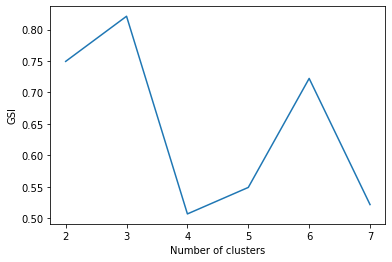

In [ ]:
X = [i for i in clus]
Y = [j for j in gsi_s]
plt.plot(X,Y)
plt.xlabel('Number of clusters')
plt.ylabel('GSI')
plt.show()

## IMC-1

In [ ]:
cluster_center_2, cluster_center_normalised_2, clusters_2 = imc1(pixel_values_2)

(16384, 3)


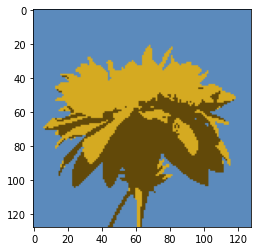

In [ ]:
segmented_image_2 = cluster_center_2[clusters_2.flatten()]
print(segmented_image_2.shape)
segmented_image_2 = segmented_image_2.reshape(image_2.shape)
plt.imshow(segmented_image_2)
plt.show()

In [ ]:
#GSI
silhouette_score(pixel_values_2, clusters_2)

0.8206487

In [ ]:
print("Separation Index",separation_index_2(pixel_values_2,clusters_2,cluster_center_2))
print("Dunn Index",dunn_index_2(pixel_values_2, clusters_2))
print("Partition Index",partition_index_2(pixel_values_2,clusters_2,cluster_center_2))

Separation Index 0.009576435679161598
Dunn Index 0.7501900569998049
Partition Index 0.002351134783017879


## IMC-2

In [ ]:
cluster_center_2, cluster_center_normalised_2, clusters_2 = imc2(pixel_values_2)

In [ ]:
print("GSI",silhouette_score(pixel_values_2, clusters_2))

GSI 0.8206523


In [ ]:
print("Separation Index",separation_index_2(pixel_values_2,clusters_2,cluster_center_2))
print("Dunn Index",dunn_index_2(pixel_values_2, clusters_2))
print("Partition Index",partition_index_2(pixel_values_2,clusters_2,cluster_center_2))

Separation Index 0.00972402028820248
Dunn Index 0.7442688175155213
Partition Index 0.004408260869963647


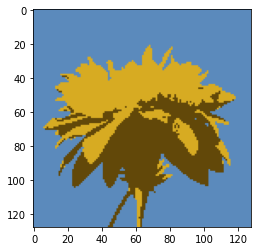

0.8206523
0.0017287675668433756
1.0300975609683428e-05
1.0396785


In [ ]:
segmented_image_2 = cluster_center_2[clusters_2.flatten()]
print(segmented_image_2.shape)
segmented_image_2 = segmented_image_2.reshape(image_2.shape)
plt.imshow(segmented_image_2)
plt.show()

## Fuzzy-C Means

In [ ]:
cluster_centers,labels = fuzzy_c_means(pixel_values_2,3)

(16384, 3)


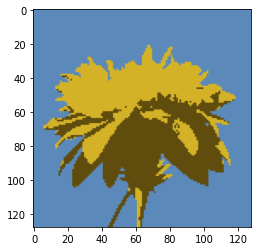

In [ ]:
segmented_image_2 = cluster_centers[labels.flatten()]
print(segmented_image_2.shape)
segmented_image_2 = segmented_image_2.reshape(image_2.shape)
plt.imshow(segmented_image_2)
plt.show()

In [ ]:
print("GSI",silhouette_score(pixel_values_2,labels))

GSI 0.82106173


In [ ]:
print("Separation Index",separation_index_2(pixel_values_2,labels,cluster_centers))
print("Dunn Index",dunn_index_2(pixel_values_2, labels))
print("Partition Index",partition_index_2(pixel_values_2,labels,cluster_centers))

Separation Index 0.03471485520790716
Dunn Index 0.7323864669915598
Partition Index 0.022486772486772486


## K-Means

In [ ]:
k = KMeans(K=3, max_iters=100)  
y_pred = k.predict(pixel_values_2) 
y_pred = y_pred.astype(int)
centers = np.uint8(k.cent())
label = y_pred.flatten()

(16384, 3)


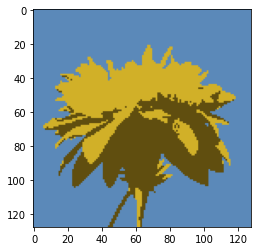

In [ ]:
segmented_image_2 = centers[label.flatten()]
print(segmented_image_2.shape)
segmented_image_2 = segmented_image_2.reshape(image_2.shape)
plt.imshow(segmented_image_2)
plt.show()

In [ ]:
#GSI
silhouette_score(pixel_values_2, label)

0.8211313

In [ ]:
print("Separation Index",separation_index_2(pixel_values_2,label,centers))
print("Dunn Index",dunn_index_2(pixel_values_2, label))
print("Partition Index",partition_index_2(pixel_values_2,label,centers))

Separation Index 0.036704217583745036
Dunn Index 0.7322409869378593
Partition Index 0.003163548074535307


##Self-Optimal Clustering

In [ ]:
cluster_center,cluster_center_normalised,clusters,bandwidth,beta,S,eta,GSI = soc(pixel_values_2)

pixel_Values_real_copy [[ 86. 133. 184.]
 [ 87. 134. 184.]
 [ 87. 134. 184.]
 ...
 [ 94. 141. 193.]
 [ 94. 141. 192.]
 [ 92. 142. 191.]]
pixel_values_copy [[0.3372549  0.55648535 0.93877554]
 [0.34117648 0.5606695  0.93877554]
 [0.34117648 0.5606695  0.93877554]
 ...
 [0.36862746 0.58995813 0.9846939 ]
 [0.36862746 0.58995813 0.97959185]
 [0.36078432 0.59414226 0.9744898 ]]
d_m [0.07854537 0.0545633  0.06475784]
S_m [0.93792701 0.66972554 0.59791785]
poly       2
1322 x - 164.8 x + 4.725
eta_m 0.07993332271404086
beta_m [1.01767072 1.46496487 1.23434193]
Cluster_Center [array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 170,  33]], dtype=uint8)]
Cluster_Center_normalised [[array([0.35686275, 0.57740587, 0.9591837 ], dtype=float32), array([0.38431373, 0.30543932, 0.04591837], dtype=float32), array([0.8352941 , 0.7112971 , 0.16836734], dtype=float32)]]
Clusters [array([0, 0, 0, ..., 0, 0, 0])]
bandwidth [array([0.07854537, 0.0545633 , 0.06475784])]
beta [1.01767072 1.46496487 1

<ipython-input-8-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 86. 133. 184.]
 [ 87. 134. 184.]
 [ 87. 134. 184.]
 ...
 [ 94. 141. 193.]
 [ 94. 141. 192.]
 [ 92. 142. 191.]]
pixel_values_copy [[0.3372549  0.55648535 0.93877554]
 [0.34117648 0.5606695  0.93877554]
 [0.34117648 0.5606695  0.93877554]
 ...
 [0.36862746 0.58995813 0.9846939 ]
 [0.36862746 0.58995813 0.97959185]
 [0.36078432 0.59414226 0.9744898 ]]
d_m [0.07862286 0.05471655 0.064578  ]
S_m [0.93792701 0.66972554 0.59791785]
poly       2
1317 x - 164.4 x + 4.723
eta_m 0.08001634823401176
beta_m [1.01772377 1.46237939 1.23906506]
Cluster_Center [array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 170,  33]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 171,  34]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 170,  33]], dtype=uint8)]
Cluster_Center_normalised [[array([0.35686275, 0.57740587, 0.9591837 ], dtype=float32), array([0.38431373, 0.30543932, 0.04591837], dtype=float32), array([0.83529

<ipython-input-8-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 86. 133. 184.]
 [ 87. 134. 184.]
 [ 87. 134. 184.]
 ...
 [ 94. 141. 193.]
 [ 94. 141. 192.]
 [ 92. 142. 191.]]
pixel_values_copy [[0.3372549  0.55648535 0.93877554]
 [0.34117648 0.5606695  0.93877554]
 [0.34117648 0.5606695  0.93877554]
 ...
 [0.36862746 0.58995813 0.9846939 ]
 [0.36862746 0.58995813 0.97959185]
 [0.36078432 0.59414226 0.9744898 ]]
d_m [0.07869563 0.05484093 0.06434172]
S_m [0.93792504 0.66775447 0.59987861]
poly       2
1287 x - 160.5 x + 4.6
eta_m 0.08011149231201947
beta_m [1.01799159 1.46079757 1.24509399]
Cluster_Center [array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 170,  33]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 171,  34]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 170,  33]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 171,  34]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [215, 171,  34]], dtyp

<ipython-input-8-f1372e459f4a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_m[i] = np.sum(np.min(pixel_values,axis=1)/(np.sum(pixel_values,axis=1)+1e-9))/(2*len(pixel_values)) * beta_m[i] #bandwidth


pixel_Values_real_copy [[ 86. 133. 184.]
 [ 87. 134. 184.]
 [ 87. 134. 184.]
 ...
 [ 94. 141. 193.]
 [ 94. 141. 192.]
 [ 92. 142. 191.]]
pixel_values_copy [[0.3372549  0.55648535 0.93877554]
 [0.34117648 0.5606695  0.93877554]
 [0.34117648 0.5606695  0.93877554]
 ...
 [0.36862746 0.58995813 0.9846939 ]
 [0.36862746 0.58995813 0.97959185]
 [0.36078432 0.59414226 0.9744898 ]]
d_m [0.0788177  0.05499994 0.06414609]
S_m [0.93792504 0.66775447 0.59987861]
poly       2
1279 x - 159.8 x + 4.588
eta_m 0.08024061678424932
beta_m [1.01805324 1.45892189 1.25090425]
Cluster_Center [array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 170,  33]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 171,  34]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 170,  33]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [213, 171,  34]], dtype=uint8), array([[ 91, 138, 188],
       [ 98,  73,   9],
       [215, 171,  34]], dt

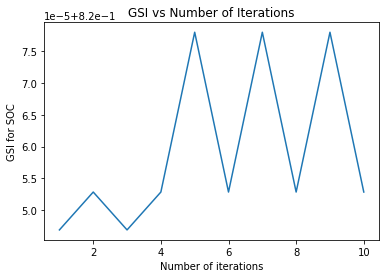

In [70]:
# graph of GSI with respect to number of iterations
X = np.arange(1,11)
plt.plot(X,GSI)
plt.xlabel('Number of iterations')
plt.ylabel('GSI for SOC')
plt.title('GSI vs Number of Iterations')
plt.show()

In [ ]:
SOC_cluster_centers = cluster_center[np.argmax(GSI)]
SOC_labels = clusters[np.argmax(GSI)]

(16384, 3)


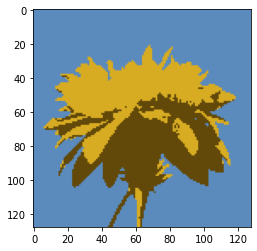

In [ ]:
segmented_image_2 = SOC_cluster_centers[SOC_labels.flatten()]
print(segmented_image_2.shape)
segmented_image_2 = segmented_image_2.reshape(image_2.shape)
plt.imshow(segmented_image_2)
plt.show()

In [ ]:
#GSI
silhouette_score(pixel_values_2, SOC_labels)

0.82066983

In [ ]:
dunn_index_2(pixel_values_2, SOC_labels)

0.744277321528371

In [ ]:
partition_index_2(pixel_values_2,SOC_labels,SOC_cluster_centers)

1.5091880392252903e-05

In [ ]:
separation_index_2(pixel_values_2,SOC_labels,SOC_cluster_centers)

0.009702719872306368